# Scoreboard Dashboard

The live scoreboard has changed the way fans follow basketball. Now, instead of needing to watch a game, fans have the option of following games through live scoreboards on several platforms. The [NBA](https://www.nba.com/games/20190104/UTACLE#/pbp) and [WNBA](https://www.wnba.com/game/20180711/NYLCON/#/play-by-play) sites have their own, along with many third party sites.

Through the [stats.nba.com](https://stats.nba.com) API, the information that powers these scoreboards is available. This notebook contains an introduction to the `scoreboardv2` endpoint of the API through the `ScoreBoard` class in the `py_ball` package. The goal is to leverage the power of Jupyter notebooks to build a prototype live scoreboard.

In [61]:
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import time

from py_ball import scoreboard, image

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `ScoreBoard` class requires three parameters:
- league_id: One of '00' (NBA) or '10' (WNBA)
- game_date: String of date in 'MM/DD/YYYY' corresponding to the day for which data is desired
- day_offset: String of an integer representing days from or before the date given in game_date for which data is desired. Positive values indicate days into the future, zero represents the current day, and negative values indicate days into the past

In [86]:
league_id = '00' #WNBA
game_date = '01/29/2019'
day_offset = '0'

scores = scoreboard.ScoreBoard(headers=HEADERS,
                               endpoint='scoreboardv2',
                               league_id=league_id,
                               game_date=game_date,
                               day_offset=day_offset)

scores.data.keys()

dict_keys(['GameHeader', 'LineScore', 'SeriesStandings', 'LastMeeting', 'EastConfStandingsByDay', 'WestConfStandingsByDay', 'Available', 'TeamLeaders', 'TicketLinks', 'WinProbability'])

The above shows the tables available from this endpoint. For the scoreboard, the `LineScore` table should contain most of the data needed.

In [87]:
scoreboard_df = pd.DataFrame(scores.data['LineScore'])
scoreboard_df.head(5)

,AST,FG3_PCT,FG_PCT,FT_PCT,GAME_DATE_EST,GAME_ID,GAME_SEQUENCE,PTS,PTS_OT1,PTS_OT10,...,PTS_QTR2,PTS_QTR3,PTS_QTR4,REB,TEAM_ABBREVIATION,TEAM_CITY_NAME,TEAM_ID,TEAM_NAME,TEAM_WINS_LOSSES,TOV
0,31,0.333,0.483,0.739,2019-01-29T00:00:00,0021800749,1,113,0,0,...,23,22,44,36,WAS,Washington,1610612764,Wizards,21-29,6
1,30,0.441,0.536,0.458,2019-01-29T00:00:00,0021800749,1,116,0,0,...,27,35,28,48,CLE,Cleveland,1610612739,Cavaliers,11-41,15
2,32,0.406,0.540,0.800,2019-01-29T00:00:00,0021800750,2,115,0,0,...,32,27,26,39,MIL,Milwaukee,1610612749,Bucks,36-13,10
3,29,0.324,0.472,0.750,2019-01-29T00:00:00,0021800750,2,105,0,0,...,27,28,28,39,DET,Detroit,1610612765,Pistons,21-28,11
4,25,0.429,0.538,0.731,2019-01-29T00:00:00,0021800751,3,126,0,0,...,37,22,35,43,OKC,Oklahoma City,1610612760,Thunder,32-18,7


In [88]:
list(scoreboard_df)

['AST',
 'FG3_PCT',
 'FG_PCT',
 'FT_PCT',
 'GAME_DATE_EST',
 'GAME_ID',
 'GAME_SEQUENCE',
 'PTS',
 'PTS_OT1',
 'PTS_OT10',
 'PTS_OT2',
 'PTS_OT3',
 'PTS_OT4',
 'PTS_OT5',
 'PTS_OT6',
 'PTS_OT7',
 'PTS_OT8',
 'PTS_OT9',
 'PTS_QTR1',
 'PTS_QTR2',
 'PTS_QTR3',
 'PTS_QTR4',
 'REB',
 'TEAM_ABBREVIATION',
 'TEAM_CITY_NAME',
 'TEAM_ID',
 'TEAM_NAME',
 'TEAM_WINS_LOSSES',
 'TOV']

The `scoreboard_df` contains some game metadata and team performance, including points by period (the table schema has fields to handle games with up to 10 overtime periods!). Additionally, each row in `scoreboard_df` corresponds to a team, not a game. However, the current time and period are not available in this DataFrame. The cell below checks the `GameHeader` table for this information.

In [89]:
game_header_df = pd.DataFrame(scores.data['GameHeader'])
game_header_df.head(5)

,ARENA_NAME,AWAY_TV_BROADCASTER_ABBREVIATION,GAMECODE,GAME_DATE_EST,GAME_ID,GAME_SEQUENCE,GAME_STATUS_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,HOME_TV_BROADCASTER_ABBREVIATION,LIVE_PC_TIME,LIVE_PERIOD,LIVE_PERIOD_TIME_BCAST,NATL_TV_BROADCASTER_ABBREVIATION,SEASON,VISITOR_TEAM_ID,WH_STATUS
0,Quicken Loans Arena,NBCSWA,20190129/WASCLE,2019-01-29T00:00:00,0021800749,1,3,Final,1610612739,FSO,,4,Q4 -,None,2018,1610612764,1
1,Little Caesars Arena,FSWIS,20190129/MILDET,2019-01-29T00:00:00,0021800750,2,3,Final,1610612765,FSD,,4,Q4 -,None,2018,1610612749,1
2,Amway Center,FSOK,20190129/OKCORL,2019-01-29T00:00:00,0021800751,3,3,Final,1610612753,FSFL,,4,Q4 -,None,2018,1610612760,1
3,Barclays Center,WGN,20190129/CHIBKN,2019-01-29T00:00:00,0021800752,4,3,Final,1610612751,YES,,4,Q4 -,None,2018,1610612741,1
4,Toyota Center,None,20190129/NOPHOU,2019-01-29T00:00:00,0021800753,5,3,Final,1610612745,ATTSN-SW,,4,Q4 - TNT,TNT,2018,1610612740,1


The `game_header_df` has the period and game time information available (columns: `LIVE_PC_TIME`, `LIVE_PERIOD`, `LIVE_PERIOD_TIME_BCAST`). With all of the above information at disposal, the list below gives some ideas for features to include on the scoreboard:
- Team logos
- Live period, time, and points
- Live team totals for other statistics
- Boxscore for team points by period

While the scoreboard can include much more information, starting with this list should provide a good foundation.

In [ ]:
def pull_game_data(game_id, count=0):
    """ pull_game_data gathers the data needed to create
    a scoreboard for the game identified by game_id

    @param game_id (str): Unique game identifier
    @param count (int): integer controlling the
        number of 'day_offset' values are fed to
        the API. This is a hack to ensure the
        data refreshes

    Returns:

        team_df (DataFrame): DataFrame containing
            team performance data
        game_df (DataFrame): DataFrame containing
            game metadata and live period/time
        away_team_logo (PngImageFile): PNG object of away team
            logo
        home_team_logo (PngImageFile): PNG object of home team
            logo
    """

    if count > 0:
        day_list = [day_offset]*count
    else:
        day_list = day_offset
            
    scores = scoreboard.ScoreBoard(headers=HEADERS,
                               endpoint='scoreboardv2',
                               league_id=league_id,
                               game_date=game_date,
                               day_offset=day_list)

    scores_df = pd.DataFrame(scores.data['LineScore'])
    header_df = pd.DataFrame(scores.data['GameHeader'])

    if game_id not in list(scores_df['GAME_ID']):
        print('Game ' + game_id + ' not available for date and league provided')

    team_df = scores_df[scores_df['GAME_ID']==game_id]
    game_df = header_df[header_df['GAME_ID']==game_id]
    team_df['FULL_NAME'] = team_df['TEAM_CITY_NAME'] + ' ' + team_df['TEAM_NAME']

    away_team = game_df['VISITOR_TEAM_ID'].iloc[0]
    home_team = game_df['HOME_TEAM_ID'].iloc[0]

    if league_id == '00':
        league = 'NBA'
    else:
        league = 'WNBA'

    away_team_logo = image.Logo(league=league,
                                team_id=str(away_team))
    home_team_logo = image.Logo(league=league,
                                team_id=str(home_team))

    if game_df['GAME_STATUS_ID'].iloc[0] != 1:
        team_df['FG3_PCT'] = 100*team_df['FG3_PCT']
        team_df['FG_PCT'] = 100*team_df['FG_PCT']
        team_df['AST'] = [int(x) for x in team_df['AST']]
        team_df['REB'] = [int(x) for x in team_df['REB']]
        team_df['TOV'] = [int(x) for x in team_df['TOV']]

    return team_df, game_df, away_team_logo.image, home_team_logo.image, [away_team, home_team]

In [8]:
team_df, game_df, away_team_logo, home_team_logo, team_ids = pull_game_data('0021800751')

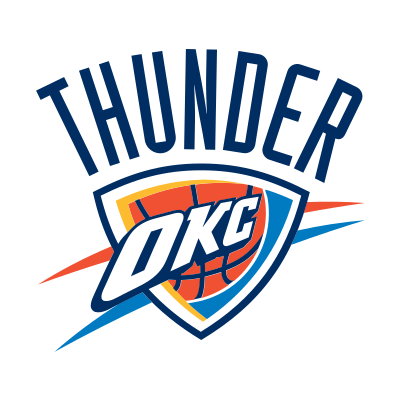

In [9]:
away_team_logo

Structuring `pull_game_data` in this manner allows refreshed game data to be pulled given a `GAME_ID`, which is crucial for any scoreboard.

In [90]:
def build_scoreboard(game_id, count=0):
    """ build_scoreboard generates a scoreboard dashboard
    for the game identified by game_id
    """

    team_df, game_df, away_team_logo, home_team_logo, team_ids = pull_game_data(game_id, count)
    away_team_id, home_team_id = team_ids

    # Away logo display
    away_bytes = BytesIO()
    away_team_logo.save(away_bytes, format='PNG')
    away_bytes = away_bytes.getvalue()

    away_logo_widget  = widgets.Image(value=away_bytes,
                                      format='png',
                                      width=128,
                                      height=128)

    # Home logo display
    home_bytes = BytesIO()
    home_team_logo.save(home_bytes, format='PNG')
    home_bytes = home_bytes.getvalue()

    home_logo_widget = widgets.Image(value=home_bytes,
                                      format='png',
                                      width=128,
                                      height=128)

    # Game metadata widgets: Team names, scores, game time and status
    away_df = team_df[team_df['TEAM_ID']==away_team_id]
    home_df = team_df[team_df['TEAM_ID']==home_team_id]
    away_name = away_df['FULL_NAME'].iloc[0]
    home_name = home_df['FULL_NAME'].iloc[0]

    away_name_widget = widgets.HTML(value='<font size="2">' + away_name + '</font>',
                                    layout=widgets.Layout(flex='auto', width='auto'))
    home_name_widget = widgets.HTML(value='<font size="2">' +  home_name + '</font>',
                                    layout=widgets.Layout(flex='auto', width='auto'))

    away_score_widget = widgets.HTML(value='<font size="5"><b>' +
                                           str(int(away_df['PTS'].iloc[0])) + '</b></font>',
                                     layout=widgets.Layout(flex='auto', width='auto'))
    home_score_widget = widgets.HTML(value='<font size="5"><b>' +
                                           str(int(home_df['PTS'].iloc[0])) + '</b></font>',
                                     layout=widgets.Layout(flex='auto', width='auto'))
    
    game_time = widgets.HTML(value='<font size="3"><b>' +
                                   str(game_df['LIVE_PERIOD_TIME_BCAST'].iloc[0]) + '</b></font>',
                             layout=widgets.Layout(flex='auto', width='auto'))
    game_status = widgets.HTML(value='<font size="3"><b>' +
                                   str(game_df['GAME_STATUS_TEXT'].iloc[0]) + '</b></font>',
                             layout=widgets.Layout(flex='auto', width='auto'))
    space = widgets.HTML(value='<font size="3">&emsp;&emsp;&emsp;&emsp;&emsp;</font>',
                         layout=widgets.Layout(flex='auto', width='auto'))

    # Score by period table generation
    period = game_df['LIVE_PERIOD'].iloc[0]
    status = game_df['GAME_STATUS_ID'].iloc[0]
    points_list = ['PTS_QTR1', 'PTS_QTR2', 'PTS_QTR3', 'PTS_QTR4']
    label_list = ['1', '2', '3', '4']

    if period >= 5:
        for ot in range(5, period+1):
            points_list.append('PTS_OT' + str(ot))
            label_list.append('OT' + str(ot))

    away_points = away_df[points_list]
    home_points = home_df[points_list]

    points_df = away_points.append(home_points)
    points_df.columns = label_list

    points_df.index = [away_name, home_name]

    away_df = away_df[['FG3_PCT', 'FG_PCT', 'AST', 'REB', 'TOV']].T
    home_df = home_df[['FG3_PCT', 'FG_PCT', 'AST', 'REB', 'TOV']].T
    away_df.columns = [away_name]
    home_df.columns = [home_name]

    # Layout widgets to control the structure of the output
    logo_layout = widgets.Layout(display='flex',
                                 flex_flow='row',
                                 align_items='center',
                                 justify_content='space-between',
                                 width='50%')
    name_layout = widgets.Layout(display='flex',
                                 flex_flow='column',
                                 align_items='center',
                                 justify_content='center',
                                 width='100%')

    dash_layout = widgets.Layout(display='flex',
                                 flex_flow='column',
                                 align_items='center',
                                 justify_content='center',
                                 width='50%')

    # Stacking output widgets horizontally and vertically
    away_names = widgets.VBox([away_name_widget, away_score_widget], layout=name_layout)
    home_names = widgets.VBox([home_name_widget, home_score_widget], layout=name_layout)
    game_meta_data = widgets.VBox([game_time, game_status], layout=dash_layout)

    # Performance and points scored by team
    away_out = widgets.Output(layout=widgets.Layout(flex='flex', width='100%'))
    with away_out:
        clear_output(wait=True)
        display(away_df)

    home_out = widgets.Output(layout=widgets.Layout(flex='flex', width='100%'))
    with home_out:
        clear_output(wait=True)
        display(home_df)

    pts_out = widgets.Output(layout=widgets.Layout(flex='flex', width='100%'))
    with pts_out:
        clear_output(wait=True)
        display(points_df)
        
    away_box = widgets.VBox([away_logo_widget, away_names, away_out], layout=dash_layout)
    home_box = widgets.VBox([home_logo_widget, home_names, home_out], layout=dash_layout)

    scoreboard_widget = widgets.HBox([away_box, home_box], layout=logo_layout)
    dashboard_widget = widgets.VBox([scoreboard_widget, widgets.HBox([space, pts_out])])

    return status, game_meta_data, dashboard_widget

In [82]:
game_id = '0021800755'

In [ ]:
%matplotlib inline

out = widgets.Output()

game_status = 0
count = 5
# game_status of 3 means that the game is over,
# so this while loop will refresh the scoreboard
# widget every thirty seconds
while game_status != 3:
    count += 1
    if count > 200:
        count = 0
    game_status, game_meta_data, dashboard_widget = build_scoreboard(game_id, count)
    with out:
        display(game_meta_data, dashboard_widget)
    time.sleep(30)
    game_meta_data.close()
    dashboard_widget.close()

## Exploration

- What other information would be useful to add to the scoreboard? Can you study the ipywidget code and add something to the scoreboard?
- Can you alter the final cell here to display multiple games?
- Try adding a player leaderboard for certain statistical categories.